TODO:
* if no seizures present, the script cannot be run. Probably same for no sd waves, too. T301_tmev_d1.270820.1131 for example!
* test again for 2 seizures in one movie

In [1]:
# todo: plot arrows here already.
# todo: apply asymmetric derivative or seizure onset for 1359?
# todo: find better limits on manual limits for sz?

In [2]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import h5py
from nd2_to_caiman import np_arr_from_nd2
import labrotation.file_handling as fh
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from math import floor, sqrt
from datetime import datetime
import json
from labrotation import json_util
import scipy
from scipy import ndimage
import datadoc_util
from statsmodels.nonparametric.smoothers_lowess import lowess
import pandas as pd
import seaborn as sns
from math import floor, atan2
import multiprocess as mp  # multiprocessing does not work with IPython. Use fork instead.
import os
import random  # for possible stochastic algorithms
from collections.abc import Iterable  # for checking if i_frame_begin is iterable
from matplotlib import cm

In [4]:
grid_shape = (8,8)

In [5]:
env_dict = dict()
if not os.path.exists("./.env"):
    print(".env does not exist")
else:
    with open("./.env", "r") as f:
        for line in f.readlines():
            l = line.rstrip().split("=")
            env_dict[l[0]] = l[1]
print(env_dict.keys())

dict_keys(['DATA_DOCU_FOLDER', 'DOWNLOADS_FOLDER', 'LOG_FOLDER', 'MATLAB_2P_FOLDER', 'FLUO_LV_MATCHED_FOLDER'])


In [6]:
if "DATA_DOCU_FOLDER" in env_dict.keys():
    data_docu_folder = env_dict["DATA_DOCU_FOLDER"]
else:
    data_docu_folder = fh.open_dir("Open Data Documentation folder")
print(data_docu_folder)

D:\PhD\Data documentation


In [7]:
ddoc = datadoc_util.DataDocumentation(data_docu_folder)
ddoc.loadDataDoc()

# Define log dictionary
To be saved as json. It should contain all parameters that make this analysis reproducible

In [8]:
parameters_log = dict()

# Open traces file

In [9]:
whole_traces_h5_fpath = fh.open_file("Open traces h5 file!")
print(whole_traces_h5_fpath)
parameters_log["filename"] = os.path.split(whole_traces_h5_fpath)[-1]

D:\PhD\Analysis_v1\T333\T333_tmev_d2_21102020_FOV_007_23-03-16_17-48-11_traces.h5


In [10]:
with h5py.File(whole_traces_h5_fpath, 'r') as hf:
    session_uuid = hf.attrs["uuid"]
    moco_intervals = hf["moco_intervals"][()]
    moco_flags = hf["moco_flags"][()]
    cnmf_intervals = hf["cnmf_intervals"][()]
    cnmf_flags = hf["cnmf_flags"][()]
    begin_end_frames = hf["begin_end_frames"][()]
    # spatial components: CNMF A field
    A_data = hf["spatial"]["data"][()]
    A_indices = hf["spatial"]["indices"][()]
    A_indptr = hf["spatial"]["indptr"][()]
    A_shape = hf["spatial"]["shape"][()]
    # temporal signals, i.e. neuron traces
    temporal = hf["traces"][()]

In [11]:
n_neurons, n_frames = temporal.shape

In [12]:
# convert spatial from sparse matrix into dense matrix of proper dimensions
spatial = scipy.sparse.csc.csc_matrix((A_data, A_indices, A_indptr), shape=A_shape).todense()
spatial = np.array(spatial)  # change type to allow np.reshape (?)
spatial = np.reshape(spatial, (512, 512, n_neurons)) # (262144 -> 512x512, i.e. "unflatten")
spatial = np.transpose(spatial, axes=[2, 1,0])  # move neuron index to end

In [13]:
res_x, res_y = spatial[0].shape

In [14]:
centers_x = np.zeros((n_neurons))
centers_y = np.zeros((n_neurons))
for i_neuron in range(n_neurons):
    xy = ndimage.measurements.center_of_mass(spatial[i_neuron].T) # transpose needed so that imshow and scatter plotting match 
    centers_x[i_neuron] = xy[0]
    centers_y[i_neuron] = xy[1]

In [15]:
spatial.shape

(432, 512, 512)

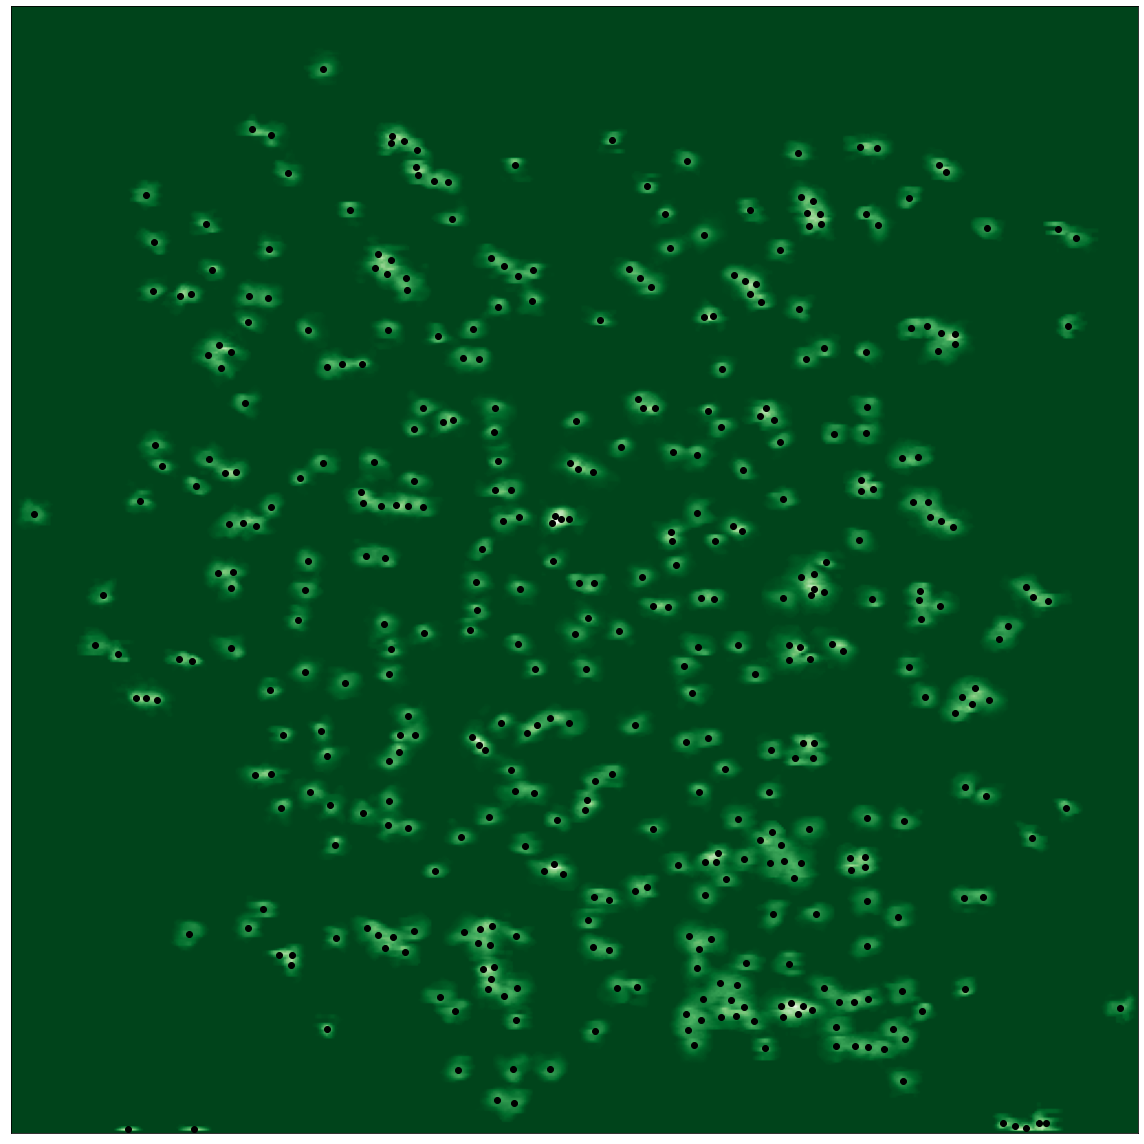

In [17]:
fig = plt.figure(figsize=(16,16))
I_NEURON = 100
plt.imshow(sum(spatial), cmap="Greens_r")
plt.grid(False)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.scatter(centers_x, centers_y, color="black")
plt.tight_layout()
plt.savefig("D:\\Downloads\\example_fov.jpg")
plt.show()

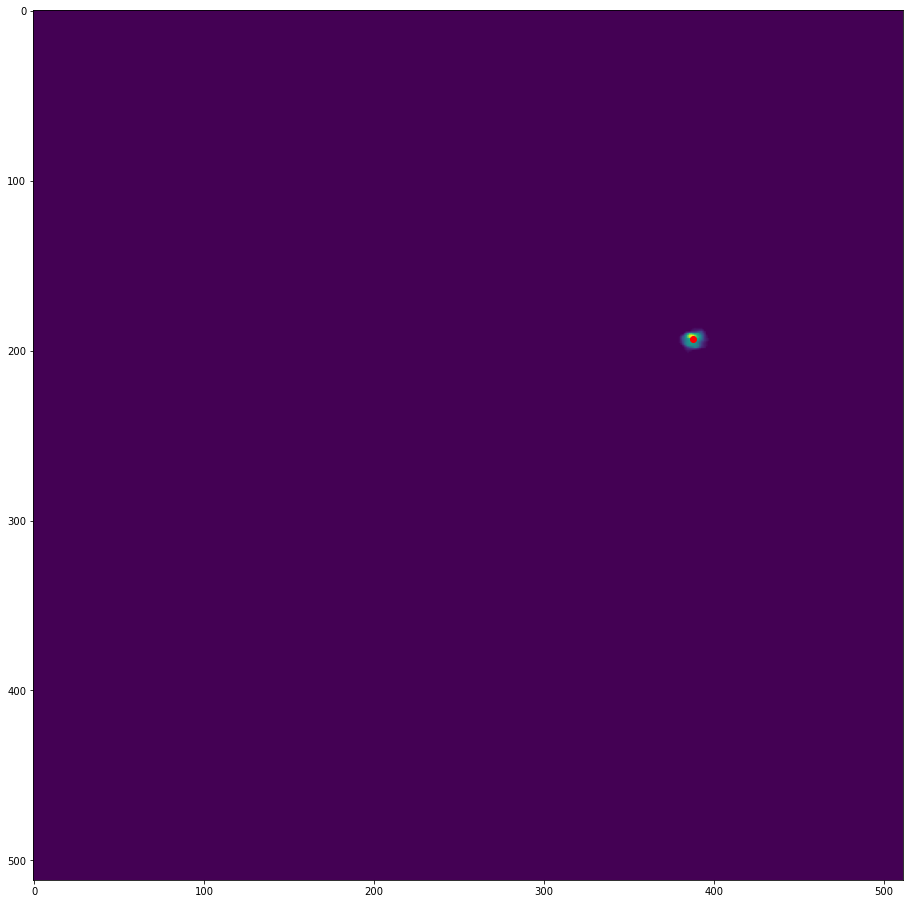

In [18]:
fig = plt.figure(figsize=(16,16))
I_NEURON = 100
plt.imshow(spatial[I_NEURON])
plt.scatter(centers_x[I_NEURON], centers_y[I_NEURON], color="red")
plt.show()

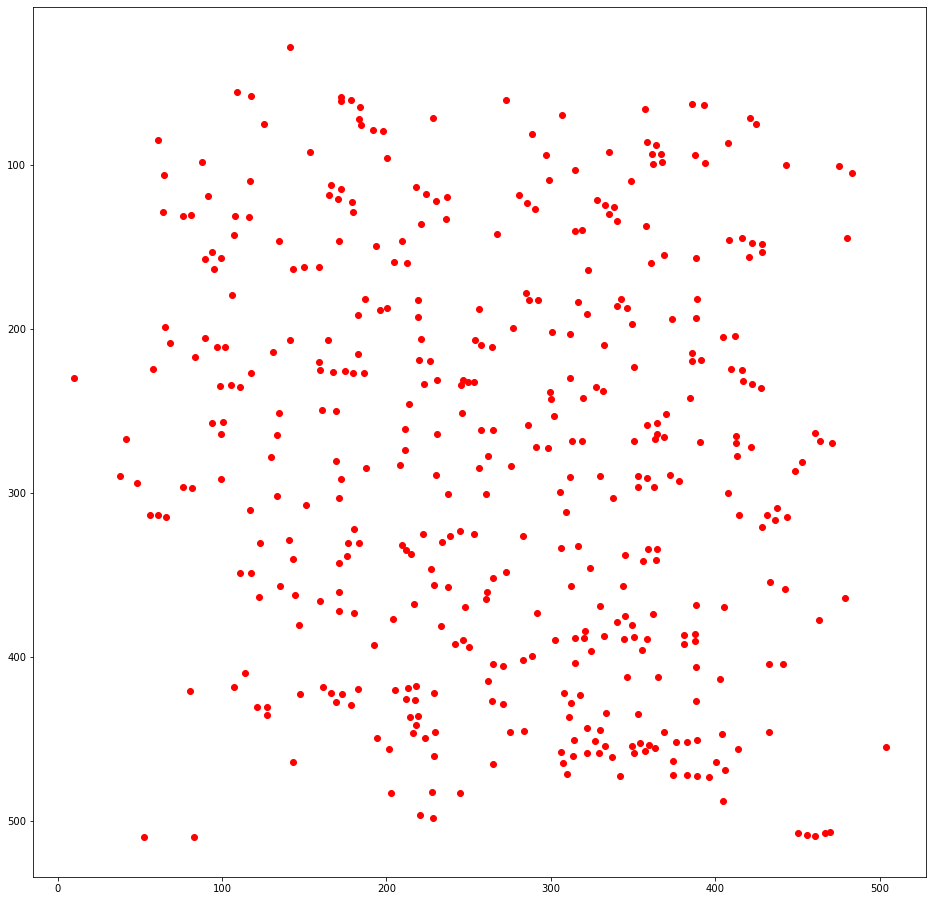

In [19]:
fig = plt.figure(figsize=(16,16))
plt.scatter(centers_x, centers_y, color="red")
ax = plt.gca()
ax.invert_yaxis() 
plt.show()

# Create x values
in best case, these should be read out of nikon metadata file...

In [20]:
x_vals = np.linspace(0, n_frames-1,num=n_frames)

## Get important frames
beginning of seizure, SD waves...

In [21]:
segments_list = ddoc.getSegmentsForUUID(session_uuid, as_df=False)

In [22]:
segments = ddoc.getSegmentsForUUID(session_uuid)

In [23]:
n_seizures = len(segments[segments["interval_type"] == "sz"])
print(f"Recording contains {n_seizures} seizure(s)")

Recording contains 1 seizure(s)


In [24]:
n_waves = len(segments[segments["interval_type"] == "sd_wave"])
print(f"Recording contains {n_waves} SD wave(s)")

Recording contains 2 SD wave(s)


In [25]:
# sort by beginning frame of sd wave
sd_waves_list = sorted(list(filter(lambda seg: seg[0] == "sd_wave", segments_list)), key= lambda x: x[1])
sz_list = sorted(list(filter(lambda seg: seg[0] == "sz", segments_list)), key= lambda x: x[1])

In [26]:
sd_waves_list

[('sd_wave', 5751, 5802), ('sd_wave', 5803, 5909)]

In [27]:
sz_list

[('sz', 5412, 5750)]

In [28]:
# group sz and sd waves. Must follow each other in order to consider one group
sz_sd_grouping = []
# group only sd waves (for sd onset analysis)
sd_grouping = []
for sz in sz_list:
    sz_sd_grouping.append([sz])
    for sd_wave in sd_waves_list:
        if sd_wave[1] - sz_sd_grouping[-1][-1][-1] == 1:
            sz_sd_grouping[-1].append(sd_wave)
for group in sz_sd_grouping:
    sd_grouping.append([])
    for segment in group:
        if segment[0] == "sd_wave":
            sd_grouping[-1].append(segment) 

In [29]:
sz_sd_grouping

[[('sz', 5412, 5750), ('sd_wave', 5751, 5802), ('sd_wave', 5803, 5909)]]

In [30]:
def getSDBeginEndFrames(i_sz):
    if i_sz >= len(sz_sd_grouping):
        raise Exception(f"getSDBeginEndFrames() Out of bounds: {i_sz}. {len(sz_sd_grouping)} segments were detected.")
    else:
        return (sd_grouping[i_sz][0][1], sd_grouping[i_sz][-1][2])

In [31]:
#sd_grouping = [[('sd_wave', 1246, 1413), ('sd_wave', 1414, 1581)], [('sd_wave', 15709, 15890), ('sd_wave', 15891, 16033)]]

In [32]:
getSDBeginEndFrames(0)

(5751, 5909)

# Filter signal

In [33]:
lowess_filtered_traces = np.zeros(temporal.shape)
lowess_filtered_xvals = np.zeros(temporal.shape)

### Run lowess filtering in parallel

In [34]:
mp.cpu_count()

8

In [35]:
def get_lowess(row):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    import numpy as np
    # Calculate fraction for lowess to use 2 s data
    FREQUENCY = 15.  # hz
    len_rec_s = len(row)/FREQUENCY  # length of movie in seconds
    FRACTION_2s = 2.0/len_rec_s
    # create x values for scatter (lowess = locally weighted scatterplot smoothing)
    x_vals = np.linspace(0, len(row)-1,num=len(row))
    lowess_filtered = lowess(row, x_vals, frac=FRACTION_2s, is_sorted=True,)  # used 0.001 for Analysis_v1
    # lowess_x = lowess_filtered.T[0]
    # lowess_y = lowess_filtered.T[1] 
    return lowess_filtered.T

In [36]:
p = mp.Pool(processes=mp.cpu_count()-2)
lowess_results = p.map(get_lowess, temporal[range(n_neurons)])

### Create 2d np array of results

In [37]:
for i_neuron in range(n_neurons):
    lowess_filtered_xvals[i_neuron,:] = lowess_results[i_neuron][0]
    lowess_filtered_traces[i_neuron,:] = lowess_results[i_neuron][1]

In [38]:
derivatives_lowess_asym = np.zeros(temporal.shape, dtype=temporal.dtype)
derivatives_raw_asym = np.zeros(temporal.shape, dtype=temporal.dtype)

derivatives_raw_sym = np.zeros(temporal.shape, dtype=temporal.dtype)
derivatives_lowess_sym = np.zeros(temporal.shape, dtype=temporal.dtype)

In [39]:
def get_trace_from_formula(raw_traces, i_neuron, sign_limits_tuples):
    """
    calculates supplied formula using raw_traces[i_neuron][a:b] slices.
    raw_traces: temporal or lowess_filtered_traces
    i_neuron: must be in range [0, n_neurons)
    sign_limits_tuples: list of tuples of the form [(a, b), (sign1, a1, b1), (sign2, a2, b2), ...].
        signi: +-1
        ai: inclusive first element to take in raw_traces
        bi: exclusive last element to take (for example, bi=-1: take all elements from ai until end of list, last element excluded)
            If bi is missing, then will take [ai:], i.e. until end of list.
    The formula used will be:
    new_traces[a:b] = sign2*raw_traces[a1:b1] + sign2*raw_traces[a2:b2] + ...
    """
    len_segment = len(raw_traces[i_neuron][sign_limits_tuples[0][0]:len(raw_traces[i_neuron]) + sign_limits_tuples[0][1]])  # sign_limits_tuples[0][1] < 0; if -1, take all elements except last etc.
    
    calculated_signal = np.zeros(len_segment, dtype=raw_traces.dtype)
    for sign_limits in sign_limits_tuples[1:]:
        if len(sign_limits) == 2:  # last element missing, i.e. [sign]*trace[first_element:]
            calculated_signal += sign_limits[0]*raw_traces[i_neuron][sign_limits[1]:]
        else:
            # take [sign]*trace[first_element:last_element]
            calculated_signal += sign_limits[0]*raw_traces[i_neuron][sign_limits[1]:sign_limits[2]]
    return calculated_signal

# It turns out that the slow waves make symmetric first derivative a better signal to get onset as local maxima. For seizure onset, 
# this will not be the case (most likely)

# symmetric derivative: dy/dt[i] = (y[i+1] - y[i-1])/2h (h:= 0.5). 
# Not entirely valid, as y[i+h] should be the value instead, but 1/2h factor can be neglected
#for i_neuron in range(n_neurons):
#    derivatives[i_neuron][1:-1] = temporal[i_neuron][2:] - temporal[i_neuron][:-2]

# extended symmetric derivative: dy/dt[i] = (y[i+2] + y[i+1] - y[i-1] - y[i-2])/4h
#for i_neuron in range(n_neurons):
#    derivatives[i_neuron][2:-2] = temporal[i_neuron][4:] + temporal[i_neuron][3:-1] - temporal[i_neuron][1:-3] - temporal[i_neuron][:-4]

# DEFAULT: super-extended symmetric derivative: dy/dt[i] = (y[i+4]+y[i+3]+y[i+2]+y[i+1] - y[i-1]-y[i-2]-y[i-3]-y[i-4])  

SYMMETRIC_FORMULA = [(4,-4), (+1,8,),(+1,7,-1), (+1,6,-2), (+1, 5, -3), (-1,3,-5), (-1,2,-6), (-1,1,-7), (-1,0,-8)]
for i_neuron in range(n_neurons):
    derivatives_raw_sym[i_neuron][4:-4] = get_trace_from_formula(temporal, i_neuron, SYMMETRIC_FORMULA)
    # derivatives_raw_sym[i_neuron][4:-4] = temporal[i_neuron][8:] + temporal[i_neuron][7:-1] + temporal[i_neuron][6:-2] + temporal[i_neuron][5:-3] - temporal[i_neuron][3:-5] - temporal[i_neuron][2:-6] - temporal[i_neuron][1:-7] - temporal[i_neuron][:-8]

ASYMMETRIC_FORMULA_PART1 = [(4, -4), (+1, 8,), (+1, 7, -1), (-1, 3, -5), (-1, 2, -6), (-1, 1, -7), (-1, 0, -8)]
ASYMMETRIC_FORMULA_PART2 = [(0, -10), (+1, 10,), (+1, 9, -1)]
# asymmetric derivative
for i_neuron in range(n_neurons):
    derivatives_raw_asym[i_neuron][4:-4] = get_trace_from_formula(temporal, i_neuron, ASYMMETRIC_FORMULA_PART1)
    #print(part2.shape)
    derivatives_raw_asym[i_neuron][:-10] += get_trace_from_formula(temporal, i_neuron, ASYMMETRIC_FORMULA_PART2) 
    # derivatives_raw_asym[i_neuron][4:-4] = temporal[i_neuron][8:] + temporal[i_neuron][7:-1] - temporal[i_neuron][3:-5] - temporal[i_neuron][2:-6] - temporal[i_neuron][1:-7] - temporal[i_neuron][:-8]
    # derivatives_raw_asym[i_neuron][:-10] += temporal[i_neuron][10:] + temporal[i_neuron][9:-1]
    
    
    
# asymmetric first derivative: dy/dt[i] = (y[i] - y[i-1])/h (h := 1)
#for i_neuron in range(n_neurons):
#    derivatives[i_neuron][1:] = temporal[i_neuron][1:] - temporal[i_neuron][:-1]

# second derivative: d^2y/dt^2[i] = (y[i+h] - 2y[i] + y[i-h])/h^2 (h:=1)
#for i_neuron in range(n_neurons):
#    derivatives[i_neuron][1:-1] = temporal[i_neuron][2:] - 2*temporal[i_neuron][1:-1] + temporal[i_neuron][:-2]

SYMMETRIC_FORMULA_LOWESS = [(2,-2), (+1,4,), (+1,3,-1), (-1,1,-3), (-1,0,-4)]
# DEFAULT: lowess-filtered extended symmetric derivative:
for i_neuron in range(n_neurons):
    derivatives_lowess_sym[i_neuron][2:-2] = get_trace_from_formula(lowess_filtered_traces, i_neuron, SYMMETRIC_FORMULA_LOWESS)
    # derivatives_lowess_sym[i_neuron][2:-2] = lowess_filtered_traces[i_neuron][4:] + lowess_filtered_traces[i_neuron][3:-1] - lowess_filtered_traces[i_neuron][1:-3] - lowess_filtered_traces[i_neuron][:-4]
    
# asymmetric derivative.
ASYMMETRIC_FORMULA_LOWESS = [(4, -4), (+1, 8,), (+1, 6, -2), (+1, 5, -3), (-1, 3, -5), (-1, 2, -6), (-1, 1, -7)]
for i_neuron in range(n_neurons):
    derivatives_lowess_asym[i_neuron][4:-4] = get_trace_from_formula(lowess_filtered_traces, i_neuron, ASYMMETRIC_FORMULA_LOWESS)
    # derivatives_lowess_asym[i_neuron][4:-4] = lowess_filtered_traces[i_neuron][8:] + lowess_filtered_traces[i_neuron][6:-2] + lowess_filtered_traces[i_neuron][5:-3] - lowess_filtered_traces[i_neuron][3:-5] - lowess_filtered_traces[i_neuron][2:-6] - lowess_filtered_traces[i_neuron][1:-7]

In [ ]:
parameters_log["SYMMETRIC_FORMULA"] = str(SYMMETRIC_FORMULA)
parameters_log["ASYMMETRIC_FORMULA_PART1"] = str(ASYMMETRIC_FORMULA_PART1)
parameters_log["ASYMMETRIC_FORMULA_PART2"] = str(ASYMMETRIC_FORMULA_PART2)
parameters_log["SYMMETRIC_FORMULA_LOWESS"] = str(SYMMETRIC_FORMULA_LOWESS)
parameters_log["ASYMMETRIC_FORMULA_LOWESS"] = str(ASYMMETRIC_FORMULA_LOWESS)

In [ ]:
plot_example_trace = False
if plot_example_trace:
    fig = plt.figure(figsize=(14,14))
    plt.plot(lowess_filtered_xvals[0], lowess_filtered_traces[0])
    plt.plot(lowess_filtered_xvals[0], temporal[0])
    plt.plot(lowess_filtered_xvals[0], derivatives_lowess[0])
    plt.xlim((i_frame_begin - 200,i_frame_end + 200))
    plt.show()

In [ ]:
n_waves_curr_sz = len(sd_grouping[i_sz])
i_frame_begin, i_frame_end  = getSDBeginEndFrames(i_sz)
n_neurons_to_plot=150

viridis_cm = cm.get_cmap('viridis', n_neurons_to_plot)
newcolors = viridis_cm(np.linspace(0, 1, n_neurons_to_plot))


fig = plt.figure(figsize=(14,14))
for i in range(n_neurons_to_plot):
    plt.plot(lowess_filtered_xvals[i], temporal[i]+i*400, c=newcolors[i])

plt.xlim((i_frame_begin - 800,i_frame_end + 1200))
#plt.ylabel("Fluorescence (a.u.)", fontsize=16)
ax = plt.gca()
ax.set_yticks([])
plt.xlabel("Frame", fontsize=16)
plt.tight_layout()
#plt.savefig(f"D:\\Downloads\\example_onset_trace_{n_neurons_to_plot}_neurons.jpg")
plt.show()

### Assign data to use for extracting onset
Also add it to log

In [ ]:
derivatives_sd = derivatives_lowess_asym
derivatives_sz = derivatives_lowess_sym

In [ ]:
derivatives_sd_source = ""
if (derivatives_sd == derivatives_lowess_asym).all():
    derivatives_sd_source = "derivatives_lowess_asym"
elif (derivatives_sd == derivatives_lowess_sym).all():
    derivatives_sd_source = "derivatives_lowess_sym"
else:
    raise Exception("Error: unable to find source of derivatives_sd (required for logging)!")
    
derivatives_sz_source = ""
if (derivatives_sz == derivatives_lowess_asym).all():
    derivatives_sz_source = "derivatives_lowess_asym"
elif (derivatives_sz == derivatives_lowess_sym).all():
    derivatives_sz_source = "derivatives_lowess_sym"
else:
    raise Exception("Error: unable to find source of derivatives_sz (required for logging)!")
    
    
parameters_log["derivatives_sd"] = derivatives_sd_source
parameters_log["derivatives_sz"] = derivatives_sz_source

# Define algorithm to extract onset times

### Find first [n_waves] local maxima for neurons in the time window

In [ ]:
MIN_DELAY_REQUIRED = 75  # at least this many frames need to pass between the onset of two SD waves in one place
parameters_log["MIN_DELAY_REQUIRED"] = str(MIN_DELAY_REQUIRED)
def get_n_maxima(derivatives, n_maxima, i_frame_begin, i_frame_end, force_2d: bool = False, set_beginning_dark: bool = False, assure_spike: bool = False, spike_height: int = 30, neighbors_per_side: int = 15, spike_half_width: int = 4):
    # n_maxima: number of maxima to find (n=1: first maximum, ...)
    # i_frame_begin: in 1-indexing, the first frame to consider for being maximum. If iterable, algorithm makes sure for each onset to
    #   fall in different segment.
    # i_frame_end: in 1-indexing, the last frame to consider for being maximum
    # force_2d: even if n_maxima = 1, return a 2d array, for example [[0], [1], ...]. If False: [0, 1, ...]
    # set_beginning_dark: if True, find global minimum in interval i_frame_begin to i_frame_end, set this as new i_frame_begin
    # assure_spike: if True, algorithm will discard maxima if they are too small spikes (compared to the immediate neighborhood)
    # spike_height: if assure_spike is True, discards maxima found that are not above the immediate neighboring values by at least this value
    # neighbors_per_side: if asssure_spike is True, this value determines the number of neighboring points on each side 
    #    (i-1, i-2, ... and i+1, i+2, ...) to use for baseline
    # spike_half_width: the spike will be assumed to be 2*spike_half_width + 1 wide. These will be not counted to neighborhood.
    onsets = []
    
    segments_provided = False
    segments = []
    if isinstance(i_frame_begin, Iterable):
        assert i_frame_begin[-1] < i_frame_end
        i_f_begin = sorted(i_frame_begin)[0]
        segments_provided = True
        segments = [(i_frame_begin[i], i_frame_begin[i+1]) for i in range(len(i_frame_begin)-1)]
        segments.append((i_frame_begin[-1], i_frame_end))
        def inSameSegment(x1, x2):
            for seg in segments:
                if x1 in range(*seg) and x2 in range(*seg):
                    return True
            return False
    else:
        i_f_begin = i_frame_begin
    for i_neuron in range(n_neurons):
        
        if set_beginning_dark:  # limit time window beginning to darkest frame in original time window
            # TODO: can do one argsort, choose from back first max that is > i_frame_begin_neuron
            i_frame_begin_neuron = np.argsort(temporal[i_neuron][i_f_begin-1:i_frame_end+1])[0] + i_f_begin + 15  # start 1 s after global minimum
            sorted_indices = np.argsort(derivatives[i_neuron][i_frame_begin_neuron-1:i_frame_end+1])
            assert i_frame_end - i_frame_begin_neuron > 30  # ad hoc value to test interval stays large enough (~2s)
        else:
            i_frame_begin_neuron = i_f_begin
            sorted_indices = np.argsort(derivatives[i_neuron][i_f_begin-1:i_frame_end+1])
        onset_frames = []
        if len(sorted_indices)< 1:
            print(i_neuron)
        
        # add largest maximum as first maximum. If one maximum per segment forced, get maximum of last segment.
        if segments_provided:
            sorted_indices_last_segment = sorted_indices[np.where(sorted_indices >= segments[-1][0] - i_frame_begin_neuron)]
            onset_frames.append(sorted_indices_last_segment[-1])
        else:
            onset_frames.append(sorted_indices[-1])
            
        # find remaining maxima fulfilling various criteria
        if sorted_indices[-1] in onset_frames:
            i_sorted = len(sorted_indices) - 2   # index of sorted values. Last element is largest, already appended
        else:
            i_sorted = len(sorted_indices) - 1  # if last segment maximum was appended, it might not have been the largest value in the whole interval.
        n_found_maxima = 1
        while n_found_maxima < n_maxima:  # could also compare to len(onset_frames)
            candidate_frame = sorted_indices[i_sorted]
            candidate_frame_whole_rec = candidate_frame + i_frame_begin_neuron-1  # frame number adjusted to whole movie
            too_close = False
            for onset_frame in onset_frames:
                if abs(candidate_frame - onset_frame) < MIN_DELAY_REQUIRED:                
                    too_close = True
                    break
                if candidate_frame > onset_frame and (i_frame_end - onset_frame) < 50:
                    too_close = True
                    break
            if not too_close:
                # if segments_provided is True, need to make sure detected onsets happen once per segment
                if (not segments_provided) or (not inSameSegment(candidate_frame, onset_frames[-1])):  
                    # if the algorithm should check for spike height, need to do it now
                    if assure_spike:
                        neighborhood = np.concatenate([derivatives[i_neuron][candidate_frame_whole_rec-spike_half_width-neighbors_per_side:candidate_frame_whole_rec-spike_half_width], derivatives[i_neuron][candidate_frame_whole_rec+spike_half_width+1:candidate_frame_whole_rec+spike_half_width+neighbors_per_side+1]])
                        bl = np.median(neighborhood)
                        if abs(derivatives[i_neuron][candidate_frame_whole_rec] - bl) > spike_height:
                            onset_frames.append(candidate_frame)
                            n_found_maxima += 1
                    else:
                        onset_frames.append(candidate_frame)
                        n_found_maxima += 1

                        
            i_sorted -= 1
        # convert to whole video time frame
        for i_onset in range(len(onset_frames)):
            onset_frames[i_onset] += i_frame_begin_neuron-1
        # algorithm finds maxima by y-value, need to sort by x-value (i.e. in time, first maximum comes first...)
        if n_maxima == 1 and not force_2d:
            onsets.append(onset_frames[0])
        else:
            onsets.append(sorted(onset_frames))
    return onsets

# Calculate SD onset times

### OPTIONAL: set beginning of interval where looking for SD wave the frame with minimum luminosity

In [ ]:
set_beginning_dark = False
parameters_log["set_beginning_dark"] = str(set_beginning_dark)

### Choose mode to extract onset values 
* Old mode: get n_waves onset values per neuron inside whole SD region. 
* New mode: Read out SD wave beginning frames from data documentation, find 1 wave each

In [ ]:
old_method = True  # new method (assuring different segments for each wave) does not bring much, unfortunately.
assure_spike = False
parameters_log["old_method"] = str(old_method)
parameters_log["assure_spike"] = str(assure_spike)
# TODO: increase distance between sd waves for this recording

if old_method:
    if n_seizures == 1:
        i_frame_begin, i_frame_end = getSDBeginEndFrames(0)
        onsets = [get_n_maxima(derivatives_sd, n_waves, i_frame_begin, i_frame_end, force_2d=True, set_beginning_dark=set_beginning_dark, assure_spike=assure_spike)]
    else:
        onsets = []
        for i_sz in range(n_seizures):
            i_frame_begin, i_frame_end = getSDBeginEndFrames(i_sz)
            n_waves_curr_sz = len(sd_grouping)
            onsets.append(get_n_maxima(derivatives_sd, n_waves_curr_sz, i_frame_begin, i_frame_end, force_2d=True, set_beginning_dark=set_beginning_dark, assure_spike=assure_spike))
else:
    #assert n_seizures == 1  # implement n_seizures > 1 case if needed
    onsets = []
    for i_sz in range(n_seizures):
        i_begin_frames = [tup_sd[1] for tup_sd in sd_grouping[i_sz]]
        i_end_frame = sd_grouping[i_sz][-1][-1]#[tup_sd[2] for tup_sd in sd_grouping[i_sz]]
        onsets.append(get_n_maxima(derivatives_sd, n_waves, i_begin_frames, i_end_frame, force_2d=True, set_beginning_dark=False))

### Plot example result

In [ ]:
def plotExampleTrace(i_neuron, i_sz):
    n_waves_curr_sz = len(sd_grouping[i_sz])
    i_frame_begin, i_frame_end  = getSDBeginEndFrames(i_sz)
    

    fig = plt.figure(figsize=(14,14))
    plt.plot(lowess_filtered_xvals[i_neuron], lowess_filtered_traces[i_neuron])  # plue
    plt.plot(lowess_filtered_xvals[i_neuron], temporal[i_neuron])  # yellow
    plt.plot(lowess_filtered_xvals[i_neuron], derivatives_sd[i_neuron])  # green
    #plt.plot(lowess_filtered_xvals[i_neuron], derivatives_lowess_sym[i_neuron])  # brownish
    vline_colors = ["red", "black", "orange", "grey"]  # add more if needed
    for i_wave in range(n_waves_curr_sz):
        plt.vlines(onsets[i_sz][i_neuron][i_wave], ymin=-500, ymax=2000, color=vline_colors[i_wave], linewidth=2)
    plt.vlines([i_frame_begin, i_frame_end], ymin=-1000, ymax=4000, color="lime", linewidth=4)
    if set_beginning_dark:
            i_frame_begin_neuron = np.argsort(temporal[i_neuron][i_frame_begin-1:i_frame_end+1])[0] + i_frame_begin + 15
            plt.vlines([i_frame_begin_neuron], ymin=-1000, ymax=4000, color="yellow", linewidth=4)
    #plt.vlines([np.argsort(temporal[I_NEURON][i_frame_begin-1:i_frame_end+1])[0]+i_frame_begin], ymin=-1500, ymax=4500, color="yellow",linewidth=3)

    #plt.vlines(sorted_indices[-1] + i_frame_begin - 1, ymin=-500, ymax=2000, color="black", linewidth=0.5)
    # TODO: mismatch in onsets[] as well as in sorted_indices[]! See plot...
    #plt.xlim((i_frame_begin - 200,i_frame_end + 200))
    plt.xlim((i_frame_begin - 800,i_frame_end + 400))
    plt.ylim((-100, 800))
    plt.ylabel("Fluorescence (a.u.)", fontsize=16)
    plt.xlabel("Frame", fontsize=16)
    plt.tight_layout()
    #plt.savefig("D:\\Downloads\\example_onset_trace.jpg")
    plt.show()

### Seizure 1

In [ ]:
sd_grouping

In [ ]:
I_NEURON = 10
I_SZ = 0
plotExampleTrace(I_NEURON, I_SZ)

### Seizure 2 (if present)
If more than 2 seizures, one should extend this notebook to generalize

In [ ]:
if n_seizures > 1:
    I_SZ = 1
    plotExampleTrace(I_NEURON, I_SZ)

## Plot sorted onset time for each neuron
Sorted by first SD wave onset, second one is plotted accordingly.

In [ ]:
onsets_np = np.array(onsets)

In [ ]:
onsets_np.shape

In [ ]:
onsets_np[0, :,1].shape

### Sort by onset values

In [ ]:
onsets_np_sorted = np.zeros(onsets_np.shape, dtype=np.uint32)
for i_sz in range(onsets_np.shape[0]):
    n_waves_curr_sz = len(sd_grouping[i_sz])
    for i_wave in range(n_waves_curr_sz):
        onsets_np_sorted[i_sz,:,i_wave] = np.argsort(onsets_np[i_sz,:,i_wave])
    # onsets_np_sorted_second is now onsets_np_sorted[:,:,1]
    #if n_waves > 1:
    #    onsets_np_sorted_second = np.argsort(onsets_np[:,1])

In [ ]:
def plotUnsortedOnsets(i_sz):
    fig = plt.figure(figsize=(12,12))
    n_waves_curr_sz = len(sd_grouping[i_sz])
    t_vals = [i_neuron for i_neuron in range(n_neurons)]
    for i_wave in range(n_waves_curr_sz):
        plt.scatter(t_vals, onsets_np[0,:,i_wave], label=f"Wave {i_wave+1}")
    plt.legend(fontsize=20)
    plt.show()

In [ ]:
plotUnsortedOnsets(0)

In [ ]:
onsets_np.shape

In [ ]:
def plotSortedOnsets(i_sz, i_sort_by_sd=0):
    fig = plt.figure(figsize=(12,12))
    t_vals = [i_neuron for i_neuron in range(n_neurons)]
    n_waves_curr_sz = len(sd_grouping[i_sz])
    for i_wave in range(n_waves_curr_sz):
        plt.scatter(t_vals, onsets_np[i_sz,onsets_np_sorted[i_sz,:,i_sort_by_sd],i_wave], label=f"Wave {i_wave+1}")
    plt.legend(fontsize=20)
    plt.show()

In [ ]:
plotSortedOnsets(0,0)

In [ ]:
plotSortedOnsets(0,1)

In [ ]:
if n_seizures > 1:
    plotSortedOnsets(1,0)

In [ ]:
if n_seizures > 1:
    plotSortedOnsets(1,1)

In [ ]:
def plotAxSortedOnsets(i_sz=0, i_sort_by_sd=0, ax=None):
    if ax is None:
        return None
    t_vals = [i_neuron for i_neuron in range(n_neurons)]
    n_waves_curr_sz = len(sd_grouping[i_sz])
    for i_wave in range(n_waves_curr_sz):
        ax.scatter(t_vals, onsets_np[i_sz,onsets_np_sorted[i_sz,:,i_sort_by_sd],i_wave], label=f"Wave {i_wave+1}")
    ax.legend(fontsize=20)
    return ax

In [ ]:
#fig, axs = plt.subplots(nrows=n_waves, ncols = 1, figsize=(18,18))
#i_row = 0
#for i_sz in range(n_seizures):
#    for i_sd in range(n_waves):
#        plotAxSortedOnsets(i_sz, i_sd, axs[i_row])
#        i_row += 1
#        #plotAxSortedOnsets(0,1,axs[1])
#        #plotAxSortedOnsets(1,0,axs[2])
#        #plotAxSortedOnsets(1,1,axs[3])
#plt.show()

In [ ]:
onsets_np_sorted.shape

## Assign cells to grid tiles

In [ ]:
def getGridTile(x, y, grid_shape):
    # based on x and y coordinates, get tile that covers this point.
    if x >= res_x or y >= res_y or x < 0 or y < 0:
        raise ValueError(f"x or y coordinate does not fit {res_x}x{res_y} FOV: x: {x}, y: {y}")
    else:
        row = y//(res_y/grid_shape[1])  # 0-indexing
        col = x//(res_x/grid_shape[0])
    return (col, row)

In [ ]:
neuron_rows = np.zeros(n_neurons, dtype=np.int16)
neuron_cols = np.zeros(n_neurons, dtype=np.int16)
for i_neuron in range(n_neurons):
    col, row = getGridTile(centers_x[i_neuron], centers_y[i_neuron], grid_shape)
    neuron_rows[i_neuron] = row
    neuron_cols[i_neuron] = col

In [ ]:
neuron_tiles = neuron_rows*grid_shape[0] + neuron_cols
# getGridTile(511,0, grid_shape)  # test function

## Create dataframe

In [ ]:
# TODO: depending on n_waves, there might be 0, 1, 2, ... SD waves
onsets_dicts = [{"neuron_id": [i for i in range(n_neurons)],  "x": centers_x, "y": centers_y, "row": neuron_rows, "col": neuron_cols, "tile": neuron_tiles} for i_sz in range(n_seizures)]
if "onsets_np" in locals():
    for i_sz in range(n_seizures):
        n_waves_curr_session = len(sd_grouping[i_sz])
        for i_wave in range(n_waves_curr_session):  # i_wave is 0-indexing, but for dictionary keys, use 1-indexing!
            onsets_dicts[i_sz]["onset"+str(i_wave+1)] = onsets_np[i_sz,:,i_wave]

In [ ]:
onsets_dfs = [pd.DataFrame(data=onsets_dicts[i_sz]) for i_sz in range(n_seizures)]

In [ ]:
for i_sz in range(n_seizures):
    n_waves_curr_session = len(sd_grouping[i_sz])
    if "onset1" in onsets_dfs[i_sz].keys():
        for i_wave in range(n_waves_curr_session):  # i_wave 0-indexing, column names should be 1-indexing 
            onsets_dfs[i_sz]["quantile"+str(i_wave+1)] = pd.qcut(onsets_dfs[i_sz]["onset"+str(i_wave+1)], 4, labels=False)
        # onsets_df["quantile2"] = pd.qcut(onsets_df["onset2"], 4, labels=False)
    else:
        print("skip")

In [ ]:
# index onsets_dfs[] by i_seizure
#onsets_dfs[0]

## Plot results

In [ ]:
onsets_dfs[0][(onsets_dfs[0]["quantile1"] == 3) & (onsets_dfs[0]["x"] > 400) & (onsets_dfs[0]["y"] > 400)]

In [ ]:
def scatterSDOnset(onsets_df, i_wave):  # i_wave should be one-indexing (1, 2,...)
    sns.set_theme(style="whitegrid")
    f, ax = plt.subplots(figsize=(18, 18))
    sns.despine(f, left=True, bottom=True)
    #sns.scatterplot(x="x", y="y",
    #                size="onset"+str(i_wave), hue="quantile"+str(i_wave),
    #                sizes=(8,80), linewidth=0,
    #                data=onsets_df, ax=ax)
    sns.scatterplot(x="x", y="y", hue="onset"+str(i_wave+1), size="onset"+str(i_wave+1),
                    sizes=(8,80), linewidth=0,
                    data=onsets_df, ax=ax)
    ax.invert_yaxis()  # invert to match imshow() and in general, nd2 videos: (0, 0) is top left corner
    ax.set_ylim((0, 512))
    ax.set_xlim((0, 512))
    plt.show()

In [ ]:
scatterSDOnset(onsets_dfs[0], 0)

## Get mean/median onset per grid

In [ ]:
# TODO: assign grid index to each neuron. Then, make average/median onset.
# Then, create pivot (of a new df, maybe, which contains grid row, column, and onset)

In [ ]:
onset_grid = [np.zeros(grid_shape, dtype=onsets_np.dtype) for i_sz in range(n_seizures)]

In [ ]:
median_onsets_dfs = [onsets_dfs[i_sz].groupby("tile", as_index=False).median() for i_sz in range(n_seizures)]

In [ ]:
for i_sz in range(n_seizures):
    for i in range(grid_shape[0]):  # go through cols
        for j in range(grid_shape[1]): # go through rows
            i_tile = i + j*grid_shape[0]
            if i_tile in median_onsets_dfs[i_sz]["tile"].values:
                onset_grid[i_sz][i][j] = median_onsets_dfs[i_sz][median_onsets_dfs[i_sz]["tile"] == i_tile]["onset1"].values[0]


In [ ]:
# shape: [n_seizures][n_sd_waves]
median_onsets_pivots = []
for i_sz in range(n_seizures):
    pivots_curr_sz = []
    for i_sd in range(len(sd_grouping[i_sz])):
        pivots_curr_sz.append(median_onsets_dfs[i_sz].pivot("row", "col", "onset"+str(i_sd+1)))
    median_onsets_pivots.append(pivots_curr_sz)

In [ ]:
median_onsets1_pivot = median_onsets_dfs[0].pivot("row", "col", "onset1")
if "onset2" in median_onsets_dfs[0].columns:
    median_onsets2_pivot = median_onsets_dfs[0].pivot("row", "col", "onset2")

In [ ]:
test_flag = False
if test_flag:
    row_np = np.zeros((64),)
    col_np = np.zeros((64),)
    for i in range(64):
        row_np[i] = i%8
        col_np[i] = i//8
    test_dict = {"col": col_np, "row": row_np}
    test_df = pd.DataFrame(test_dict)
    test_df["val"] = 8*test_df["col"] + test_df["row"]
    test_pivot = test_df.pivot("col", "row", "val")
    f, ax = plt.subplots(figsize=(12, 12))
    #sns.heatmap(median_onsets1_pivot, annot=False, linewidths=.5, ax=ax)
    sns.heatmap(test_pivot, annot=False, linewidths=.5, ax=ax)
    #ax.invert_yaxis()
    plt.show()

In [ ]:
def plotSDGrid(i_sz, i_sd):
    f, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(median_onsets_pivots[i_sz][i_sd], annot=False, linewidths=.5, ax=ax)
    #ax.invert_yaxis()
    #ax.invert_xaxis()
    #ax.set_ylim((0, 7))
    #ax.set_xlim((0, 7))
    plt.show()

In [ ]:
plotSDGrid(1,0)

In [ ]:
n_sz = n_seizures

In [ ]:
quantiles1_df = [onsets_dfs[i_sz].groupby(["quantile1"], as_index=False).mean() for i_sz in range(n_sz)]
if "quantile2" in onsets_dfs[0].keys():
    quantiles2_df = [onsets_dfs[i_sz].groupby(["quantile2"], as_index=False).mean() for i_sz in range(n_sz)]
#quantilessz_df = [onsets_dfs[i_sz].groupby(["quantile_sz"], as_index=False).mean() for i_sz in range(n_sz)]

In [ ]:
# Move from nd2/video-style coordinate system (top left = (0, 0)) to usual plotting coordinate style (bottom left = (0, 0))
for i_df, q1_df in enumerate(quantiles1_df):
    df = q1_df
    df["y_mirrored"] = df.apply(lambda row: -1*row["y"], axis=1)
    quantiles1_df[i_df] = df
    
if "quantile2" in onsets_dfs[0].keys():
    for i_df, q2_df in enumerate(quantiles2_df):
        df = q2_df
        df["y_mirrored"] = df.apply(lambda row: -1*row["y"], axis=1)
        quantiles2_df[i_df] = df

In [ ]:
def get_dx(df, colname="x", quantile_colname="quantile1"):
    max_quantile = df[quantile_colname].max()
    min_quantile = df[quantile_colname].min()
    x1 = df[df[quantile_colname] == max_quantile][colname].values[0]
    x0 = df[df[quantile_colname] == min_quantile][colname].values[0]
    return x1-x0
def xyToThetaR(vec):
    # given (x, y), return (theta, r)
    return (atan2(vec[1], vec[0]), sqrt(pow(vec[0], 2) + pow(vec[1], 2)))

# descartes coordinates
vec1 = [(get_dx(quantiles1_df[i], "x", "quantile1"), get_dx(quantiles1_df[i], "y_mirrored", "quantile1")) for i in range(n_sz)]
if "quantiles2_df" in locals():
    vec2 = [(get_dx(quantiles2_df[i], "x", "quantile2"), get_dx(quantiles2_df[i], "y_mirrored", "quantile2") ) for i in range(n_sz)]
#vecsz = [(get_dx(quantilessz_df[i], "x", "quantile_sz"), get_dx(quantilessz_df[i], "y_mirrored", "quantile_sz")) for i in range(n_sz)]
# polar coordinates as (theta, r)
arrows = {}  # sz, sd1, sd2 order
vec1pol = [xyToThetaR(vec1el) for vec1el in vec1]
arrows["sd1"] = [(vec1polel[0], 2) for vec1polel in vec1pol]  # categorical length, sz > sd1 > sd2

if "quantiles2_df" in locals():
    vec2pol = [xyToThetaR(vec2el) for vec2el in vec2]
    arrows["sd2"] = [(vec2polel[0], 1) for vec2polel in vec2pol]
#vecszpol = [xyToThetaR(vecszel) for vecszel in vecsz]
#arrows["sz"] = [( vecszpolel[0], 3) for vecszpolel in vecszpol]

In [ ]:
# 431 432 433
# 434 435 436
# 437 438 439
# 4310 4311 4312
colors = {"sz": "blue", "sd1" : "green", "sd2": "red"}
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='polar')
for event_type in ["sd1", "sd2"]:
    for i_seizure in range(n_sz):
        ax.set_ylim(0, 3)
        ax.annotate('', xy=arrows[event_type][i_seizure], xytext=(0, 0),arrowprops=dict(facecolor=colors[event_type], edgecolor='none', width=4, headwidth=8, alpha=0.9))
ax.set_rgrids(np.linspace(0, 3, num=4))
ax.set_yticklabels(["", "sd2", "sd1", "sz"])
plt.show()

In [ ]:
def plot3DOnset(i_sz, i_sd):
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    surf=ax.plot_trisurf(onsets_dfs[i_sz]['x'], onsets_dfs[i_sz]['y'], onsets_dfs[i_sz]['onset'+str(i_sd+1)], cmap=plt.cm.jet, linewidth=0.2)
    #ax.view_init(10, 90)
    plt.show()

In [ ]:
#plot3DOnset(0,0)

# Seizure onset analysis

In [ ]:
#sz = segments[segments["interval_type"] == "sz"]  
#assert len(sz) == 1# there should be only one
seizure_begin_frames = [sz_sd_grouping[i_sz][0][1] for i_sz in range(n_seizures)]
seizure_end_frames = [sz_sd_grouping[i_sz][0][2] for i_sz in range(n_seizures)]

In [ ]:
small_window = False
large_window = False
extra_large_window = False
manual_limits = True
if small_window:
    lower = -2
    upper = 10
    parameters_log["sz_window_type"] = "small_window"
    
elif large_window:
    lower = -5
    upper = 100
    parameters_log["sz_window_type"] = "large_window"
elif extra_large_window:  # used for T352 1339 recording with symmetric lowess-filtered signal
    lower = -20
    upper = 105
    parameters_log["sz_window_type"] = "extra_large_window"
elif manual_limits: # might be necessary to set limits manually
    sz_lower_limits = [295, 14965]  # 745
    sz_upper_limits = [320, 14982]  # 768 
    lower = [-seizure_begin_frames[i] + sz_lower_limits[i] for i in range(len(seizure_begin_frames))]
    upper = [-seizure_end_frames[i] + sz_upper_limits[i] for i in range(len(seizure_end_frames))]
    parameters_log["sz_window_type"] = "manual_limits"
else:
    lower = -2
    upper = 20
    parameters_log["sz_window_type"] = "other"

if (small_window or large_window or extra_large_window) and not(manual_limits):
    sz_lower_limits = [seizure_begin_frames[i]+lower for i in range(len(seizure_begin_frames))]
    sz_upper_limits = [seizure_begin_frames[i]+upper for i in range(len(seizure_begin_frames))]
parameters_log["lower_sz"] = str(lower)
parameters_log["upper_sz"] = str(upper)
parameters_log["sz_lower_limits"] = str(sz_lower_limits)
parameters_log["sz_upper_limits"] = str(sz_upper_limits)

In [ ]:
onsets_szs = [get_n_maxima(derivatives_sz, 1,sz_lower_limits[i_sz]-2, sz_upper_limits[i_sz]) for i_sz in range(n_seizures)]
onsets_szs_np = np.array(onsets_szs)

In [ ]:
onsets_szs_np.shape

In [ ]:
np.where(onsets_szs[0] > seizure_begin_frames[0]+10)

In [ ]:
def plotSortedSzOnset(i_sz):
    fig = plt.figure(figsize=(12,12))
    plt.scatter([i_neuron for i_neuron in range(n_neurons)], sorted(onsets_szs[0]))
    plt.show()

## Plot sorted cell sz onset

In [ ]:
fig, axs = plt.subplots(nrows=n_seizures, ncols=1, figsize=(18,18))
if n_seizures > 1:
    for i_sz in range(n_seizures):
        axs[i_sz].set_title(f"Seizure {i_sz+1}")
        axs[i_sz].scatter([i_neuron for i_neuron in range(n_neurons)], sorted(onsets_szs[i_sz]))
else: # only 1 sz
    axs.set_title(f"Seizure")
    axs.scatter([i_neuron for i_neuron in range(n_neurons)], sorted(onsets_szs[i_sz]))
plt.show()

In [ ]:
for i_sz in range(n_seizures):
    print(i_sz)
    onsets_dfs[i_sz]["onset_sz"] = onsets_szs_np[i_sz]
    onsets_dfs[i_sz]["quantile_sz"] = pd.qcut(onsets_dfs[i_sz]["onset_sz"], 4, labels=False)

In [ ]:
for i_sz in range(n_seizures):
    fig= plt.figure(figsize=(16,5))
    sns.histplot(data=onsets_dfs[i_sz], x="onset_sz")
    plt.show()


In [ ]:
def plotTraceWithDetectedOnset(i_neuron, i_sz):
    fig = plt.figure(figsize=(14,14))
    plt.plot(lowess_filtered_xvals[i_neuron], lowess_filtered_traces[i_neuron])
    plt.plot(lowess_filtered_xvals[i_neuron], temporal[i_neuron])
    plt.plot(lowess_filtered_xvals[i_neuron], derivatives_sz[i_neuron])
    plt.vlines(onsets_szs[i_sz][i_neuron], ymin=-500, ymax=2000, color="red", linewidth=2)
    #plt.vlines(sorted_indices[-1] + i_frame_begin - 1, ymin=-500, ymax=2000, color="black", linewidth=0.5)
    # TODO: mismatch in onsets[] as well as in sorted_indices[]! See plot...
    plt.vlines([sz_lower_limits[i_sz], sz_upper_limits[i_sz]], ymin=-500, ymax=2000, color="black", linewidth=2)
    plt.xlim((seizure_begin_frames[i_sz] - 50,seizure_begin_frames[i_sz] + 200))
    plt.show()

In [ ]:
I_NEURON = 10
I_SZ = 0
#plotTraceWithDetectedOnset(I_NEURON, I_SZ)

In [ ]:
def plotSZOnsets3D(i_sz):
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    surf=ax.plot_trisurf(onsets_dfs[i_sz]['x'], onsets_dfs[i_sz]['y'], onsets_dfs[i_sz]['onset_sz'], cmap=plt.cm.jet, linewidth=0.2)
    #ax.view_init(10, 90)
    plt.show()

In [ ]:
#plotSZOnsets3D(0)

In [ ]:
def plotSzOnset(i_sz):
    sns.set_theme(style="whitegrid")
    f, ax = plt.subplots(figsize=(18, 18))
    sns.despine(f, left=True, bottom=True)
    #sns.scatterplot(x="x", y="y", hue="onset_sz", size="onset_sz",
    #                sizes=[5, 40, 80, 160, 240, 320], linewidth=0,
    #                data=onsets_df, ax=ax, palette=hues)
    sns.scatterplot(x="x", y="y", hue="quantile_sz", size="onset_sz",
                    sizes=(10,80), linewidth=0,
                    data=onsets_dfs[i_sz], ax=ax)
    ax.invert_yaxis()  # invert to match imshow() and in general, nd2 videos: (0, 0) is top left corner
    plt.show()

In [ ]:
plotSzOnset(1)

In [ ]:
sz_onset_grids = [np.zeros(grid_shape, dtype=onsets_szs_np[0].dtype) for i_sz in range(n_seizures)]

In [ ]:
mean_onsets_dfs = [onsets_dfs[i_sz].groupby("tile", as_index=False).mean() for i_sz in range(n_seizures)]

In [ ]:
for i_sz in range(n_seizures):
    for i in range(grid_shape[0]):  # go through cols
        for j in range(grid_shape[1]): # go through rows
            i_tile = i + j*grid_shape[0]
            if i_tile in mean_onsets_dfs[i_sz]["tile"].values:
                sz_onset_grids[i_sz][i][j] = mean_onsets_dfs[i_sz][mean_onsets_dfs[i_sz]["tile"] == i_tile]["onset_sz"].values[0]

In [ ]:
#mean_sz_onsets_pivots = [mean_onsets_dfs[i_sz].pivot_table(index="row", columns="col", values="onset_sz", aggfunc="median") for i_sz in range(n_seizures)]
# mean_sz_onsets_pivots_old = [mean_onsets_dfs[i_sz].pivot("row", "col", "onset_sz") for i_sz in range(n_seizures)]
mean_sz_onsets_pivots = [onsets_dfs[i_sz].pivot_table(index="row", columns="col", values="onset_sz", aggfunc="median") for i_sz in range(n_seizures)]

In [ ]:
for i_sz in range(n_seizures):
    f, ax = plt.subplots(figsize=(10, 10))
    plt.suptitle(f"Seizure {i_sz+1}")
    sns.heatmap(mean_sz_onsets_pivots[i_sz], annot=False, linewidths=.5, ax=ax)
    #ax.invert_yaxis()
    #ax.invert_xaxis()
    plt.show()

In [ ]:
quantilessz_df = [onsets_dfs[i_sz].groupby(["quantile_sz"], as_index=False).mean() for i_sz in range(n_sz)]

In [ ]:
for i_df, sz_df in enumerate(quantilessz_df):
    df = sz_df
    df["y_mirrored"]= df.apply(lambda row: -1*row["y"], axis=1)
    quantilessz_df[i_df] = df

In [ ]:
def get_dx(df, colname="x", quantile_colname="quantile1"):
    max_quantile = df[quantile_colname].max()
    min_quantile = df[quantile_colname].min()
    x1 = df[df[quantile_colname] == max_quantile][colname].values[0]
    x0 = df[df[quantile_colname] == min_quantile][colname].values[0]
    return x1-x0
def xyToThetaR(vec):
    # given (x, y), return (theta, r)
    return (atan2(vec[1], vec[0]), sqrt(pow(vec[0], 2) + pow(vec[1], 2)))

# descartes coordinates
vecsz = [(get_dx(quantilessz_df[i], "x", "quantile_sz"), get_dx(quantilessz_df[i], "y_mirrored", "quantile_sz")) for i in range(n_sz)]
# polar coordinates as (theta, r)
vecszpol = [xyToThetaR(vecszel) for vecszel in vecsz]
arrows["sz"] = [( vecszpolel[0], 3) for vecszpolel in vecszpol]

In [ ]:
colors = {"sz": "blue", "sd1" : "green", "sd2": "red"}
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='polar')
w = [2, 4, 6, 8]
for event_type in ["sd1", "sd2", "sz"]:
    for i_seizure in range(n_sz):
        ax.set_ylim(0, 3)
        ax.annotate('', xy=arrows[event_type][i_seizure], xytext=(0, 0),arrowprops=dict(facecolor=colors[event_type], edgecolor='none', width=w[i_seizure], headwidth=8, alpha=0.9))
ax.set_rgrids(np.linspace(0, 3, num=4))
ax.set_yticklabels(["", "sd2", "sd1", "sz"])
plt.show()

## Check traces of all neurons

In [ ]:
for i_sz in range(n_seizures):
    fig = plt.figure(figsize=(14,8))
    t_steps = np.array([i_frame for i_frame in range(sz_lower_limits[i_sz],sz_upper_limits[i_sz])])
    for i_neuron in range(n_neurons):
        plt.plot(t_steps, lowess_filtered_traces[i_neuron][sz_lower_limits[i_sz]:sz_upper_limits[i_sz]])
    plt.vlines(onsets_dfs[i_sz]["onset_sz"], ymin= 0,ymax= 500, linewidth=0.5)
    plt.show()

## Check quantiles traces and detected onsets

In [ ]:
for i_sz in range(n_seizures):
    sz_quantile_groups = onsets_dfs[i_sz].groupby("quantile_sz")
    t_steps = np.array([i_frame for i_frame in range(sz_lower_limits[i_sz],sz_upper_limits[i_sz])])
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18,24), sharex=True)
    for i_group, quantile_group in sz_quantile_groups:
        for i_neuron in quantile_group.neuron_id:
            axs[i_group].plot(t_steps, lowess_filtered_traces[i_neuron][sz_lower_limits[i_sz]:sz_upper_limits[i_sz]])
        axs[i_group].set_title(f"Seizure {i_sz+1} quantile {i_group+1}")
        axs[i_group].vlines(quantile_group.onset_sz, ymin=0, ymax=300)

# Compare SZ, SD onset per neuron

In [ ]:
n_seizures

In [ ]:
for i_sz in range(n_seizures):
    n_waves_curr_sz = len(sd_grouping[i_sz])
    fig = plt.figure(figsize=(12,12))
    t_vals = [i_neuron for i_neuron in range(n_neurons)]
    for i_wave in range(n_waves_curr_sz):
        plt.scatter(t_vals, onsets_np[i_sz, onsets_np_sorted[i_sz,:,i_wave],i_wave], label=f"Wave {i_wave+1}")
    plt.scatter(t_vals,onsets_szs_np[i_sz, onsets_np_sorted[i_sz,:,i_wave]], label="Sz")
    plt.legend(fontsize=20)
    plt.suptitle(f"Seizure {i_sz+1}")
    plt.show()

In [ ]:
#fig = plt.figure(figsize=(18,18))
#for i_neuron in range(n_neurons):
#    t_onset = onsets_df[onsets_df["neuron_id"] == i_neuron]["onset1"].values[0]
#    tsteps = [t for t in range(t_onset-100, t_onset+100)]
#    plt.plot(tsteps, lowess_filtered_traces[i_neuron][t_onset-100:t_onset+100])
#plt.vlines([tsteps[100]], ymin=-2000, ymax=10000)
#ax = plt.gca()
#plt.show()

# Plot sz onset for each neuron

In [ ]:
def plotOnsetEachNeuron(i_sz):
    fig = plt.figure(figsize=(18,18))

    for i_neuron in range(n_neurons):
        t_onset = onsets_dfs[i_sz][onsets_dfs[i_sz]["neuron_id"] == i_neuron]["onset_sz"].values[0]
        tsteps = [t for t in range(t_onset-50, t_onset+200)]
        plt.plot(tsteps, lowess_filtered_traces[i_neuron][t_onset-50:t_onset+200])
    plt.vlines([tsteps[100]], ymin=-2000, ymax=5000)
    ax = plt.gca()
    plt.show()

In [ ]:
plotOnsetEachNeuron(0)

# Save to hdf5 file

In [ ]:
export_folder, export_fname = os.path.split(whole_traces_h5_fpath)
export_fname_root = os.path.splitext(export_fname)[0][:-7]
# assuming file name was xy_traces.h5
export_fname = export_fname_root + "_grid.h5"
export_fpath = os.path.join(export_folder, export_fname)
print(f"Saving results to\n\t{export_fpath}")

In [ ]:
if os.path.exists(export_fpath):
    raise Exception(f"File was not saved because it already exists:\n\t{export_fpath}\nRename it or make a back-up and delete it, then try again.")
else:
    if n_seizures == 1:
        onsets_dfs[0].to_hdf(export_fpath, key="uuid"+session_uuid)
    else:
        # need to combine the dataframes
        for i_sz in range(n_seizures):
            onsets_dfs[i_sz]["i_sz"] = i_sz
        pd.concat(onsets_dfs).to_hdf(export_fpath, key="uuid"+session_uuid)

## Save parameters used

In [ ]:
export_params_fname = export_fname_root + "_gridparams.json"
export_params_fpath = os.path.join(export_folder, export_params_fname)
print(f"Saving results to\n\t{export_params_fpath}")

In [ ]:
if os.path.exists(export_params_fpath):
    raise Exception(f"File was not saved because it already exists:\n\t{export_params_fpath}\nRename it or make a back-up and delete it, then try again.")
else:
    with open(export_params_fpath, 'w') as fp:
        json.dump(parameters_log, fp, indent=4)